### Import the necessary packages

In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
from scipy.stats import skew, norm, probplot
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

### Popularity Recommender

In [2]:
#Class for Popularity based Recommender System model
class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations


### Load dataset

Prepare Dataset

In [17]:
track_metadata_df = pd.read_csv('song_data.csv')
count_play_df = pd.read_csv('10000.txt', sep='\t', header=None, names=['user','song','play_count'])

print('First see of track metadata:')
print('Number of rows:', track_metadata_df.shape[0])
print('Number of unique songs:', len(track_metadata_df.song_id.unique()))
display(track_metadata_df.head())
print('Note the problem with repeated track metadata. Let\'s see of counts play song by users:')
display(count_play_df.shape, count_play_df.head())


First see of track metadata:
Number of rows: 1000000
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


Note the problem with repeated track metadata. Let's see of counts play song by users:


(2000000, 3)

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [19]:
unique_track_metadata_df = track_metadata_df.groupby('song_id').max().reset_index()

print('Number of rows after unique song Id treatment:', unique_track_metadata_df.shape[0])
print('Number of unique songs:', len(unique_track_metadata_df.song_id.unique()))
display(unique_track_metadata_df.head())

Number of rows after unique song Id treatment: 999056
Number of unique songs: 999056


,song_id,title,release,artist_name,year
0,SOAAABI12A8C13615F,Afro Jazziac,To Birdland And Hurry,Herbie Mann,2000
1,SOAAABT12AC46860F0,Herre Gud Ditt Dyre Namn Og Ære,Som Den Gyldne Sol Frembryter,Bergen Big Band,0
2,SOAAABX12A8C13FEB2,N.Y.C. Remix,Paris Can´t Wait,Guardner,0
3,SOAAACR12A58A79456,Irresistible,Wowie Zowie,Superchumbo,2002
4,SOAAACY12A58A79663,Untitled 1,Pine Cone Temples,Thuja,0


In [20]:
user_song_list_count = pd.merge(count_play_df, 
                                unique_track_metadata_df, how='left', 
                                left_on='song', 
                                right_on='song_id')
user_song_list_count.rename(columns={'play_count':'listen_count'},inplace=True)
del(user_song_list_count['song_id'])


### Exploratory Data Analysis

In [21]:
display(user_song_list_count.head())
user_song_list_count.listen_count.describe().reset_index().T

,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
listen_count,2e+06,3.04548,6.57972,1,1,1,3,2213


In [22]:
print('{:d} users, {:.2%} of total play counts, listening a single more than 200 times'.format(
    count_play_df.user[count_play_df.play_count>200].unique().shape[0],
    count_play_df.play_count[count_play_df.play_count>200].count()/count_play_df.shape[0]))
display(count_play_df.play_count[count_play_df.play_count>200].describe().reset_index().T)


118 users, 0.01% of total play counts, listening a single more than 200 times


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
play_count,140,327.107,209.115,201,225,267,353.75,2213


In [23]:
lunatic = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-10].values[0]
print('- How much days the most obsessed user can be the fan of a unique song: {:.1f}'.format((lunatic*3.5)/60/24))
display(track_metadata_df[track_metadata_df.song_id.isin(
                  count_play_df[count_play_df.play_count>count_play_df.play_count.max()-10].song.values)])


- How much days the most obsessed user can be the fan of a unique song: 5.4


,song_id,title,release,artist_name,year
567847,SOFCGSE12AF72A674F,Starshine,Gorillaz,Gorillaz,2000


In [24]:
obsessed = count_play_df.play_count[count_play_df.play_count>count_play_df.play_count.max()-1500].values[1]
print('- How much days the second obsessed user can be the fan of a unique song: {:.1f}'.format((obsessed*3)/60/24))
display(track_metadata_df[track_metadata_df.song_id.isin(count_play_df[count_play_df.play_count==920].song.values)])


- How much days the second obsessed user can be the fan of a unique song: 1.9


,song_id,title,release,artist_name,year
927746,SOUAGPQ12A8AE47B3A,Crack Under Pressure,Stress related / Live and learn,Righteous Pigs,1998


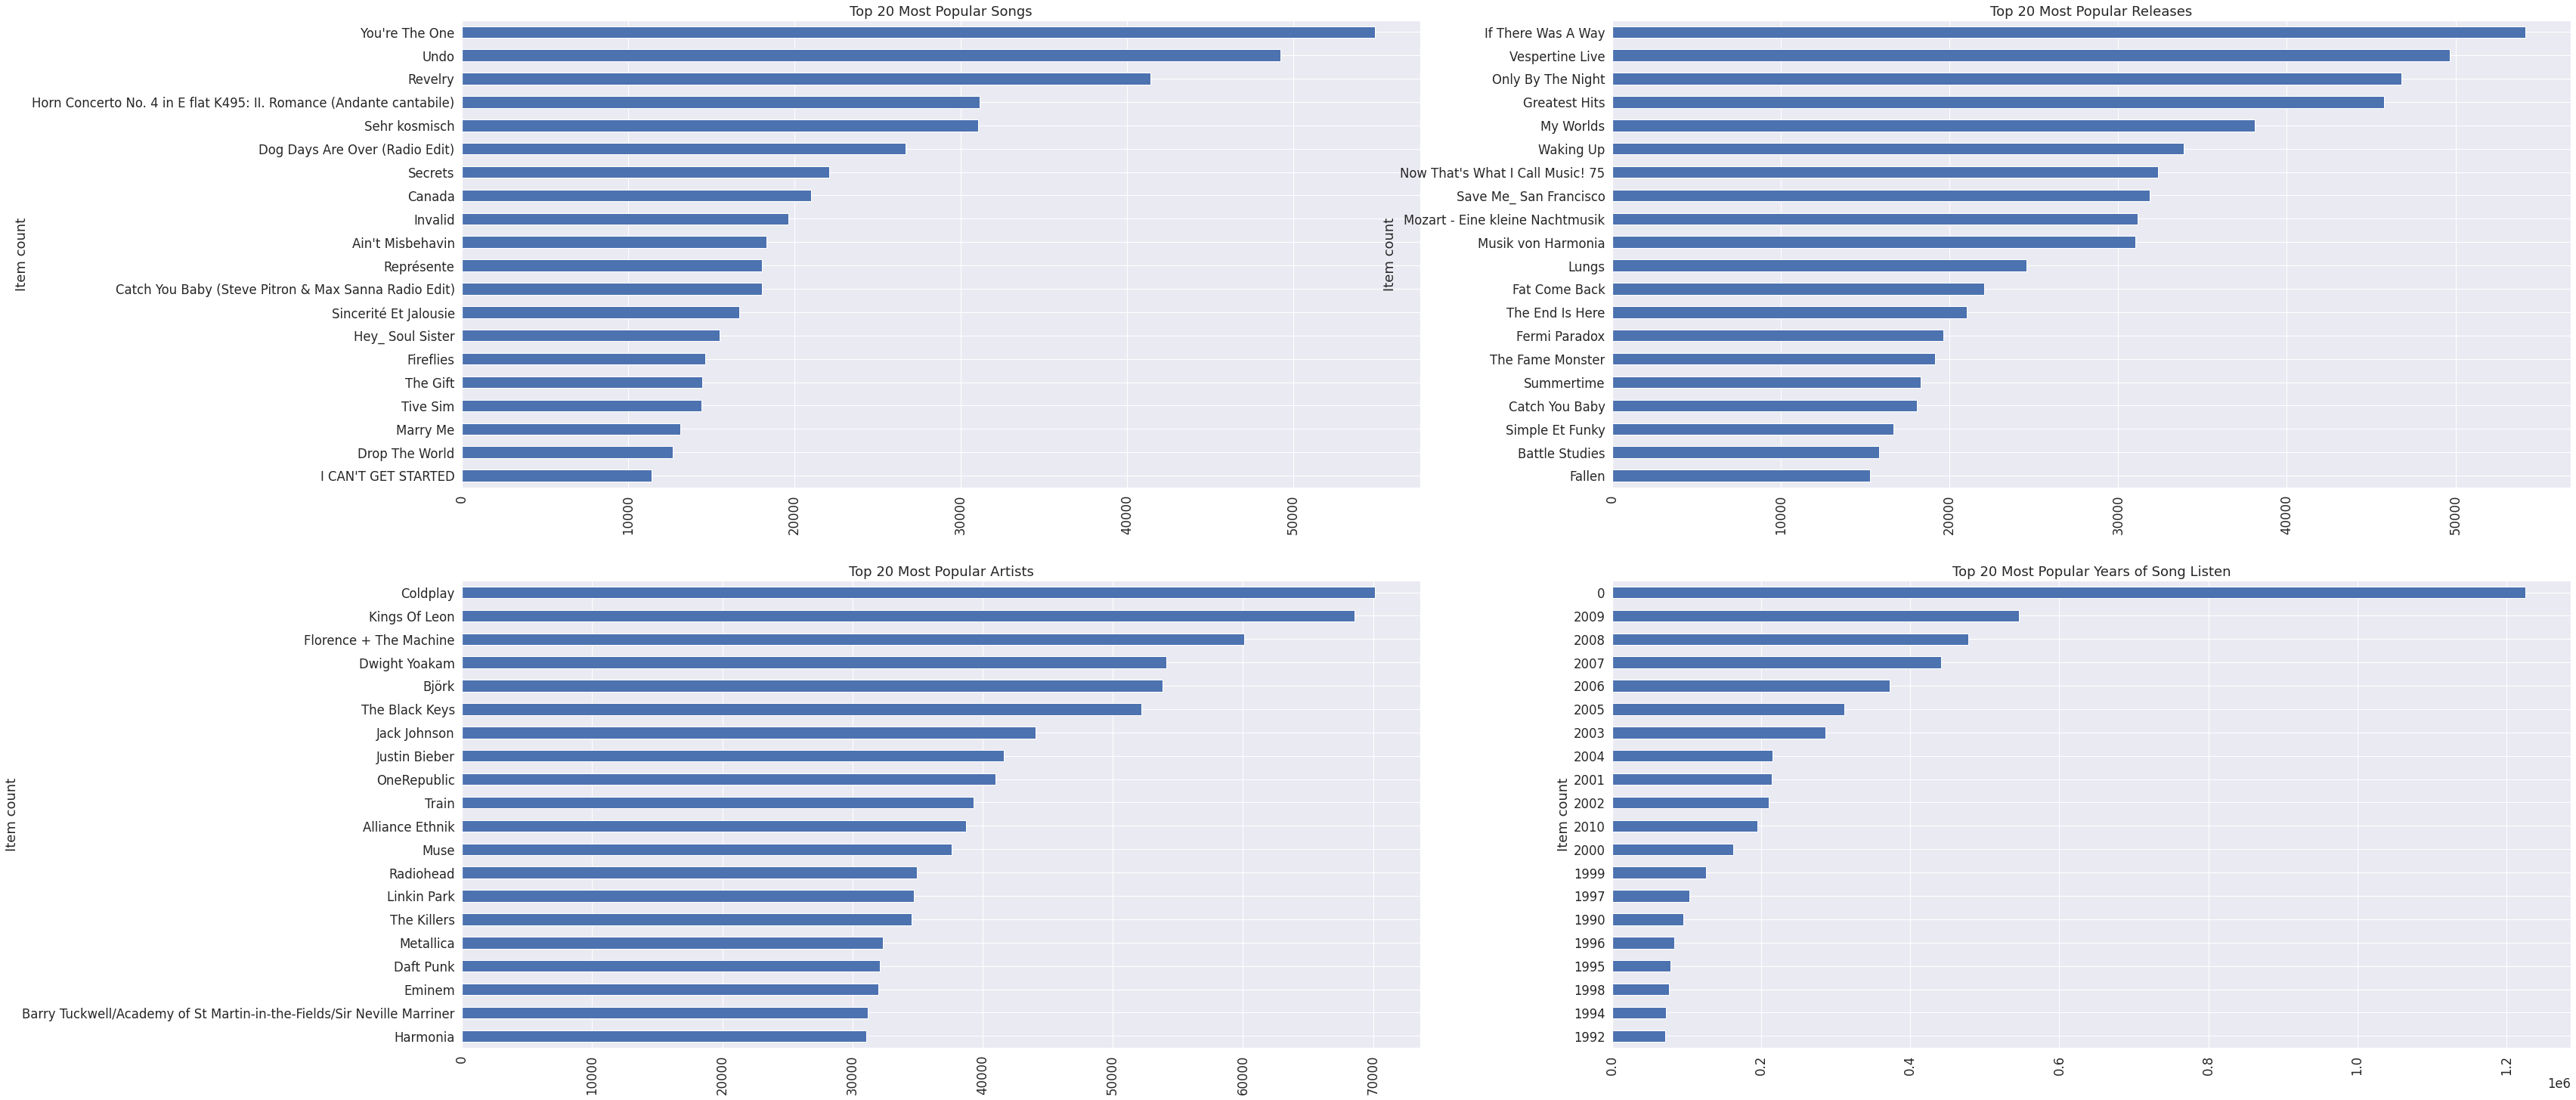

In [25]:
fig = plt.figure(figsize=(50, 25))
a1 = fig.add_subplot(221)
popular_songs = user_song_list_count[['title','listen_count']].groupby('title').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_songs.plot(kind='barh', title='Top 20 Most Popular Songs', legend=False, ax=a1)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a2 = fig.add_subplot(222)
popular_release = user_song_list_count[['release','listen_count']].groupby('release').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f2 = popular_release.plot(kind='barh', title='Top 20 Most Popular Releases', legend=False, ax=a2)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a3 = fig.add_subplot(223)
popular_artist = user_song_list_count[['artist_name','listen_count']].groupby('artist_name').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_artist.plot(kind='barh', title='Top 20 Most Popular Artists', legend=False, ax=a3)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

a4 = fig.add_subplot(224)
popular_year = user_song_list_count[['year','listen_count']].groupby('year').sum().\
                sort_values('listen_count', ascending=False).head(20).sort_values('listen_count')
f1 = popular_year.plot(kind='barh', title='Top 20 Most Popular Years of Song Listen', legend=False, ax=a4)
plt.xticks(rotation='vertical')
plt.ylabel('Item count')

plt.show()


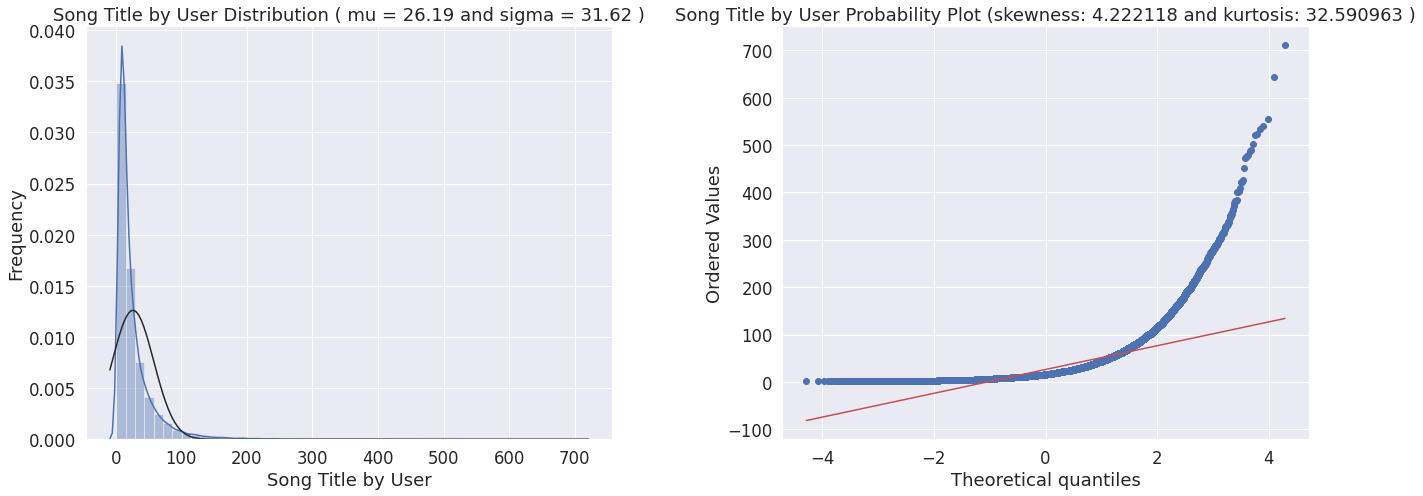

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
title,76353,26.1941,31.6251,1,9,16,31,711


In [26]:
user_song_count_distribution = user_song_list_count[['user','title']].groupby('user').count().\
                                reset_index().sort_values(by='title',ascending = False)

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(user_song_count_distribution.title, 'Song Title by User')
user_song_count_distribution.title.describe().reset_index().T


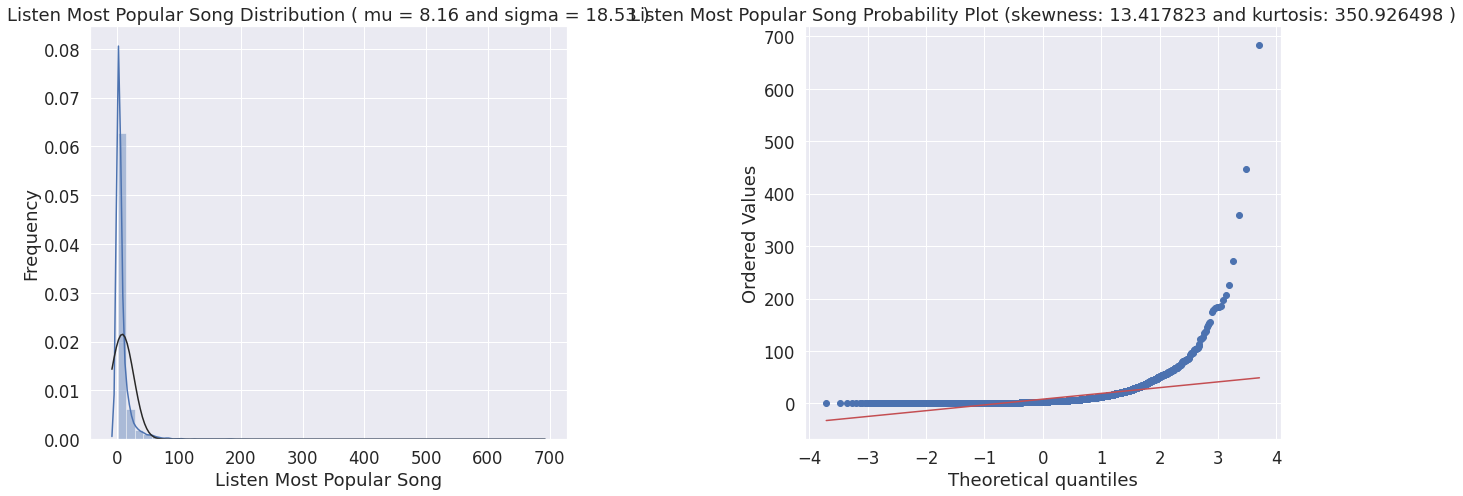

In [27]:
QQ_plot(user_song_list_count[user_song_list_count.title=="You're The One"].listen_count, 'Listen Most Popular Song')


### Recommendation Engine
The basis of the recommendation engine is always the recorded interaction between the users and products.

**Types of Recommendation Engines**
The major area of distinction in different recommendation engines comes from the entity that they assume is the most important in the process of generating recommendations.

* User-based recommendation engines: With the user as the central entity, the algorithm will look for similarities among users and on the basis of those similarities will come up with the recommendation.
* Content-based recommendation engines: With the content that we are trying to recommend as central entity, the algorithm will attempt to find features about the content and find similar content. Then these similarities will be used to make recommendations to the end users.
* Hybrid-recommendation engines: Sometimes termed as collaborative filtering recommendation engines, these are one of the most effective classes of recommendation engines, as they take the best features of both classes, users and content of recommendation engines.

**Popularity-Based Recommendation Engine** <br>
The most simplest recommendation engine is the Popularity-Based, that basically standing, if some item is liked by a vast majority of our user base, then it is a good idea to recommend that item to users who have not interacted with that item. The code to develop this kind of recommendation is extremely easy and is effectively just a summarization procedure that determine which items of the content have the most users and then that will become our standard recommendation set for each user.

In [28]:
def create_popularity_recommendation(train_data, user_id, item_id, n=10):
    #Get a count of user_ids for each unique song as recommendation score
    train_data_grouped = train_data.groupby([item_id]).agg({user_id: 'count'}).reset_index()
    train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    #Sort the songs based upon recommendation score
    train_data_sort = train_data_grouped.sort_values(['score', item_id], ascending = [0,1])
    
    #Generate a recommendation rank based upon score
    train_data_sort['Rank'] = train_data_sort.score.rank(ascending=0, method='first')
        
    #Get the top n recommendations
    popularity_recommendations = train_data_sort.head(n)
    return popularity_recommendations

In [29]:
recommendations = create_popularity_recommendation(user_song_list_count,'user','title', 15)
display(recommendations)


,title,score,Rank
6837,Sehr kosmisch,8277,1.0
8726,Undo,7032,2.0
1965,Dog Days Are Over (Radio Edit),6949,3.0
9497,You're The One,6729,4.0
6499,Revelry,6145,5.0
6826,Secrets,5841,6.0
3438,Horn Concerto No. 4 in E flat K495: II. Romanc...,5385,7.0
2596,Fireflies,4795,8.0
3323,Hey_ Soul Sister,4758,9.0
8495,Tive Sim,4548,10.0


In [30]:
display(create_popularity_recommendation(user_song_list_count,'user','artist_name', 10))


,artist_name,score,Rank
649,Coldplay,29422,1.0
2850,The Black Keys,19862,2.0
1651,Kings Of Leon,18747,3.0
1107,Florence + The Machine,18112,4.0
1370,Jack Johnson,17801,5.0
2946,The Killers,16063,6.0
2374,Radiohead,14890,7.0
736,Daft Punk,14715,8.0
2073,Muse,14005,9.0
1554,Justin Bieber,13959,10.0


### Item Similarity Based Recommendation Engine
To provide a more personal recommendation to the user we need apply a recommendation engine that consider some kid of similarities between users and theirs items. In other words, it is a recommendation engine based on calculating similarities between a user's items and the other items in our dataset. Usually to define similarity among a set of items, we need a feature set on the basis of which both items can be described. In our case it will mean features of the songs on the basis of which one song can be differentiated from another.

Since our dataset don't have this data, we can use the the Jaccard index to do an implicit similarity, based on common users, in terms of the users who listen to these songs. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:imageThe basic idea remains that if two songs are being listened to by a large fraction of common users out of the total listeners, the two songs can be said to be similar to each other.

So, we need calculate the similarity of each song in the user's list to those in our dataset, using the similarity metric defined previously, but we need attention to it can become a computation-intensive step when we have a large number of songs. To make the computation more feasible,probably you use a cluster or, in our case, we limited ours items to the most popular 5,000 songs so it is quite unlikely that we would miss out on any important recommendations.



In [31]:
total_play_count = sum(user_song_list_count.listen_count)
play_count = user_song_list_count[['song', 'listen_count']].groupby('song').sum().\
             sort_values(by='listen_count',ascending=False).head(5000)

print('5,000 most popular songs represents {:3.2%} of total listen.'.format(float(play_count.sum())/total_play_count))

song_subset = list(play_count.index[:5000])
user_subset = list(user_song_list_count.loc[user_song_list_count.song.isin(song_subset), 'user'].unique())
user_song_list_count_sub = user_song_list_count[user_song_list_count.song.isin(song_subset)]
display(user_song_list_count_sub.head())


5,000 most popular songs represents 81.88% of total listen.


,user,song,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [32]:
is_model = item_similarity_recommender_py()
is_model.create(user_song_list_count_sub, 'user', 'title')
user_id = list(user_song_list_count_sub.user)[7]
user_items = is_model.get_user_items(user_id)

#Recommend songs for the user using personalized model
is_model.recommend(user_id)


No. of unique songs for the user: 33
no. of unique songs in the training set: 4867
Non zero values in cooccurence_matrix :120655


,user_id,song,score,rank
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Quiet Houses,0.044710,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Meadowlarks,0.043836,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Heard Them Stirring,0.042740,3
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Tiger Mountain Peasant Song,0.041485,4
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Sun It Rises,0.040973,5
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Your Protector,0.039942,6
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Oliver James,0.039287,7
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,Great Indoors,0.036765,8
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,White Winter Hymnal,0.036345,9
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,If I Could,0.034576,10


In [33]:
display(user_song_list_count_sub[(user_song_list_count_sub.user==user_id) & (user_song_list_count_sub.listen_count>5)])


,user,song,listen_count,title,release,artist_name,year
16,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOMGIYR12AB0187973,6,Behind The Sea [Live In Chicago],Live In Chicago,Panic At The Disco,0
43,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOYHEPA12A8C13097F,8,Moonshine,Thicker Than Water,Jack Johnson,2003


As you can see, although the algorithms seem to have done a good job of customizing the recommendations, it is clear that we can improve them, so we go to the next recommendation system a bit more complex.

### Matrix factorization based recommendations
Matrix factorization based recommendation engines) are probably the most used recommendation engines when it comes to implementing recommendation engines in production.

Matrix factorization are methods that reduce a matrix into constituent parts, such that when these matrices are multiplied we get the original matrix. It make it easier to calculate more complex matrix operations. Matrix factorization methods, also called matrix decompositions methods, are a foundation of linear algebra in computers, even for basic operations such as solving systems of linear equations, calculating the inverse, and calculating the determinant of a matrix.

Matrix factorization can be used to discover latent features between two different kinds of entities. For example, we can try to explain a song in mathematical terms by measuring its beats, tempo, and other such features and then define similar features in terms of the user. Once we have consciously defined such "features", we can use them to find matches for a user based on some similarity criteria. You can use matrix factorization to discover these latent features and they seem to work great.

The starting point of any matrix factorization-based method is the utility matrix, a matrix of user Vs item dimension. Not, this is a sparse matrix, since not all item is used by the user. The process of matrix factorization means finding out a low rank approximation of the utility matrix. So we want to break down the utility matrix U into two low rank matrices so that we can recreate the matrix U by multiplying those two matrices:

Assuming the process helps us identify latent factors/features, meaning as K, our aim is to find two matrices X and Y such that their product (matrix multiplication) approximates R.

X = |U| x K matrix (A matrix with dimensions of num_users * factors)

Y = |P| x K matrix (A matrix with dimensions of factors * num_songs)

To make a recommendation to the user, we can multiply the corresponding user's row from the first matrix by the item matrix and determine the items from the row with maximum ratings. That will become our recommendations for the user. The first matrix represents the association between the users and the latent features, while the second matrix takes care of the associations between items (songs in our case) and the latent features.

Matrix Factorization and Singular Value Decomposition (SVD)
There are multiple algorithms available for determining factorization of any matrix. We use one of the simplest algorithms, which is the singular value decomposition or SVD. You can follow these steps to determine the factorization of a matrix using the output of SVD function.

Factorize the matrix to obtain U, S, and V matrices.
Reduce the matrix S to first k components. (The function we are using will only provide k dimensions, so we can skip this step.)
Compute the square root of reduced matrix Sk to obtain the matrix Sk1/2.
Compute the two resultant matrix U*Sk1/2 and Sk1/2*V as these will serve as our two factorized matrices
We can then generate the prediction of user i for product j by taking the dot product of the ith row of the first matrix with the jth column of the second matrix.

Let's create tree functions to help us on it:

* compute_svd: It use the svds function provided by the scipy library to break down our utility matrix into three different matrices, and prosed with the others tree steps above.
* compute_estimated_matrix: use the decomposed matrices by SVD and provide the predictions.


In [34]:
def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

def show_recomendations(uTest, num_recomendations = 10):
    for user in uTest:
        print('-'*70)
        print("Recommendation for user id {}".format(user))
        rank_value = 1
        i = 0
        while (rank_value <  num_recomendations + 1):
            so = uTest_recommended_items[user,i:i+1][0]
            if (small_set.user[(small_set.so_index_value == so) & (small_set.us_index_value == user)].count()==0):
                song_details = small_set[(small_set.so_index_value == so)].\
                    drop_duplicates('so_index_value')[['title','artist_name']]
                print("The number {} recommended song is {} BY {}".format(rank_value, 
                                                                      list(song_details['title'])[0],
                                                                      list(song_details['artist_name'])[0]))
                rank_value+=1
            i += 1


The first thing that we notice is that we have no concept of "rating" in our data. All we have are the play counts of various songs. This is a well known problem in the case of recommendation engines and is called the "implicit feedback" problem. There are many ways to solve this problem but we will look at a very simple and intuitive solution. We will replace the play count with a fractional play count. The logic being that this will measure the strength of "likeness" for a song in the range of [0,1].



In [35]:
user_song_list_listen = user_song_list_count[['user','listen_count']].groupby('user').sum().reset_index()
user_song_list_listen.rename(columns={'listen_count':'total_listen_count'},inplace=True)
user_song_list_count_merged = pd.merge(user_song_list_count,user_song_list_listen)
user_song_list_count_merged['fractional_play_count'] = \
    user_song_list_count_merged['listen_count']/user_song_list_count_merged['total_listen_count']

display(user_song_list_count_merged[user_song_list_count_merged.user =='d6589314c0a9bcbca4fee0c93b14bc402363afea']\
        [['user','song','listen_count','fractional_play_count']].head())


,user,song,listen_count,fractional_play_count
299,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,0.038961
300,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,0.003247
301,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,0.003247
302,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,0.003247
303,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,0.022727


The next transformation of data that is required is to convert our dataframe into a numpy matrix in the format of utility matrix. We will convert our dataframe into a sparse matrix, as we will have a lot of missing values and sparse matrices are suitable for representation of such a matrix. Since we won't be able to transform our song IDs and user IDs into a numpy matrix, we will convert these indices into numerical indices. Then we will use these transformed indices to create our sparse numpy matrix.



In [36]:
user_codes = user_song_list_count_merged.user.drop_duplicates().reset_index()
user_codes.rename(columns={'index':'user_index'}, inplace=True)
user_codes['us_index_value'] = list(user_codes.index)

song_codes = user_song_list_count_merged.song.drop_duplicates().reset_index()
song_codes.rename(columns={'index':'song_index'}, inplace=True)
song_codes['so_index_value'] = list(song_codes.index)

small_set = pd.merge(user_song_list_count_merged,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']]

data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.us_index_value.values
col_array = mat_candidate.so_index_value.values

data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

display(data_sparse)

print('User used to performed the item similarity based recommendations earlie:.')
display(user_codes[user_codes.user =='b80344d063b5ccb3212f76538f3d9e43d87dca9e'])


<76353x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2000000 stored elements in COOrdinate format>

User used to performed the item similarity based recommendations earlie:.


,user_index,user,us_index_value
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,0


In [37]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]

U, S, Vt = compute_svd(urm, K)
uTest = [4,5,6,7,8,873,23]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

show_recomendations(uTest)


----------------------------------------------------------------------
Recommendation for user id 4
The number 1 recommended song is 911 BY Wyclef Jean / Mary J. Blige
The number 2 recommended song is If I Ain't Got You BY Alicia Keys
The number 3 recommended song is Sample Track 2 BY Simon Harris
The number 4 recommended song is Kennedy Rag BY Suzy Thompson
The number 5 recommended song is Clocks BY Coldplay
The number 6 recommended song is Yellow BY Coldplay
The number 7 recommended song is Hey_ Soul Sister BY Train
The number 8 recommended song is The Scientist BY Coldplay
The number 9 recommended song is Eco BY Jorge Drexler
The number 10 recommended song is Kryptonite BY 3 Doors Down
----------------------------------------------------------------------
Recommendation for user id 5
The number 1 recommended song is Eenie Meenie BY Sean Kingston and Justin Bieber
The number 2 recommended song is Sample Track 2 BY Simon Harris
The number 3 recommended song is U Smile BY Justin Bieber

In [38]:
uTest = [0]
#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)
show_recomendations(uTest)


Predictied ratings:
----------------------------------------------------------------------
Recommendation for user id 0
The number 1 recommended song is Basic Space BY The xx
The number 2 recommended song is Infinity BY The xx
The number 3 recommended song is I Wanna Be Sedated (Remastered Album Version ) BY Ramones
The number 4 recommended song is Fantasy BY The xx
The number 5 recommended song is The Big Gundown BY The Prodigy
The number 6 recommended song is CIEÑ BY Milczenie Owiec
The number 7 recommended song is Home BY Edward Sharpe & The Magnetic Zeros
The number 8 recommended song is Cosmic Love BY Florence + The Machine
The number 9 recommended song is Speak BY Godsmack
The number 10 recommended song is You've Got The Love BY Florence + The Machine
